# Sellers Data Analysis

Since our analysis of the orders dataset revealed that while `wait_time` was one of the more signicant factors in explaining `review_score`, the low R-squared suggested that there were other factors outside of the orders dataset.

Here we'll look at the the sellers dataset to uncover which elements are associated with the `review_score`.

If poor reviews are linked to particular sellers, perhaps we can identify the sellers who repeatedly perform poorly and try to understand why. 

We can then use this to respond to the CEO's request to improve Olist's profit margins.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


## Inspect Features

In [161]:
from olist.seller import Seller
seller = Seller()
sellers = seller.get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,revenue,profits_before_it_costs
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,15.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307,2370.307,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,1.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800,95.800,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,1.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999,87.999,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201,96.799,-3.201


In [162]:
sellers.rename(columns={'wait_time': 'seller_wait_time', 'review_score':'seller_review_score'}, inplace=True)

In [163]:
# Get summary stats for each column
sellers.describe()

,delay_to_carrier,seller_wait_time,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,revenue,profits_before_it_costs
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,0.402786,12.160414,6.619192,0.124570,0.592130,4.086880,562.131313,33.617508,38.085185,1.162150,4566.515906,938.213880,376.082567,986.186944,424.055631
std,2.391687,7.103208,5.914010,0.191870,0.279057,0.810166,1941.000427,107.133714,122.417269,0.443348,14185.211617,1660.107616,1276.183916,1655.679175,1274.295160
min,0.000000,1.214178,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,6.500000,0.650000,-22499.517000,80.650000,-22419.517000
25%,0.000000,8.289263,1.000000,0.000000,0.478261,3.818424,0.000000,2.000000,3.000000,1.000000,239.800000,119.946750,19.892500,173.099250,93.000000
50%,0.000000,11.120969,4.000000,0.063856,0.600000,4.200000,100.000000,7.000000,8.000000,1.000000,893.500000,460.221000,250.859500,504.049000,285.790500
75%,0.000000,14.240673,10.000000,0.166667,0.750000,4.625000,380.000000,23.000000,26.000000,1.152009,3586.022500,1183.160250,676.667750,1223.955000,720.593750
max,45.434039,189.863160,23.000000,1.000000,1.000000,5.000000,40890.000000,1854.000000,2039.000000,15.000000,229472.630000,24387.263000,17967.605000,24387.263000,17967.605000


In [164]:
sellers.describe().columns

Index(['delay_to_carrier', 'seller_wait_time', 'months_on_olist',
       'share_of_one_stars', 'share_of_five_stars', 'seller_review_score',
       'cost_of_reviews', 'n_orders', 'quantity', 'quantity_per_order',
       'sales', 'revenues', 'profits', 'revenue', 'profits_before_it_costs'],
      dtype='object')

## Distribution plots

Let's look at the distributions of these features in relevant groupings

### Distribution for `delay_to_carrier`, `seller_wait_time`

`delay_to_carrier` represents the average delay (in days) by a seller of getting an order to the carrier and is calculated for each seller. We can see this as representing a delay in an order attributable to the seller.

`seller_wait_time` represents the average `wait_time` (in days), from the customer placing an order online to getting delivery of the order, and is calculated per seller. 
(NOTE: this differs from the `wait_time` feature in the Orders dataset in that it has been calculated to be the average `wait_time` *for each seller*). 



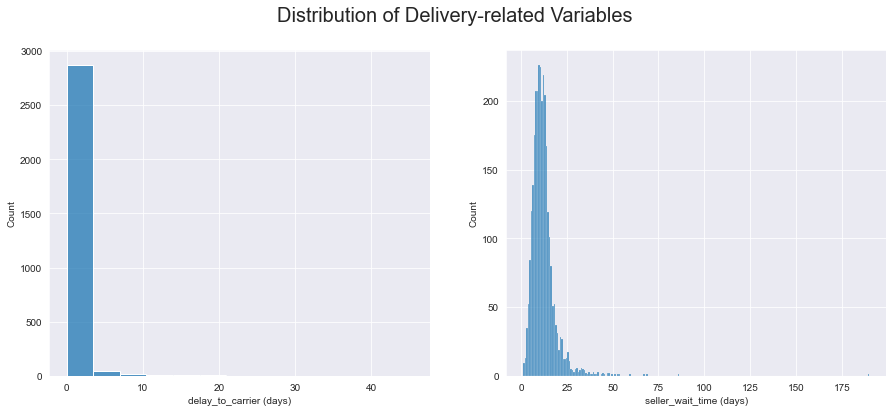

In [171]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1,2)
plt.figure(figsize=(15,6)).suptitle('Distribution of Delivery-related Variables', fontsize=20)
plt.close(1)

# 'delay_to_carrier' histogram
ax1 = plt.subplot(121)
ax1 = sns.histplot(sellers.delay_to_carrier)
plt.xlabel('delay_to_carrier (days)')

# 'seller_wait_time' histogram
ax2 = plt.subplot(122)
ax2 = sns.histplot(sellers.seller_wait_time)
plt.xlabel('seller_wait_time (days)')

plt.show(); 

In [169]:
sellers[['delay_to_carrier','seller_wait_time']].describe()

,delay_to_carrier,seller_wait_time
count,2970.000000,2970.000000
mean,0.402786,12.160414
std,2.391687,7.103208
min,0.000000,1.214178
25%,0.000000,8.289263
50%,0.000000,11.120969
75%,0.000000,14.240673
max,45.434039,189.863160


**Interpretation of Results**

- From these distribution plots and summary stats, we can see that delays in the order caused by the seller are quite rare, and so `delay_to_carrier` may not have enough data points to provide a complete enough explanation for low review scores.

- While the plot for `seller_wait_time` is heavily right-skewed, this appears to be the effect of only a few outliers. The mean is still close to the median, and most sellers are clustered tightly around the center. The coefficient of variation (standard deviation / mean) also indicates low variance when less than one (7.10 / 12.16 = 0.58).

In [10]:
# How many sellers contribute to delays?
num_sellers_delay = len((sellers[sellers['delay_to_carrier'] > 0]))
num_sellers_delay

243

In [11]:
#What percentage of sellers contribute to delays?
round(num_sellers_delay / len(sellers), 2) * 100

8.0

In [12]:
# What is the average review score for sellers that have delayed shipment to carriers?
sellers[sellers['delay_to_carrier'] > 0].review_score.mean()


3.3051861527612707

In [13]:
#How does that compare to the review score of all sellers? 
sellers.review_score.mean()

4.086880345061921

With sellers who have had delayed shipment to carriers, there is a 0.78 (4.09 - 3.31) decrease in avg. review score. Let's keep 'delay_to_carrier' as a feature to include in OLS Regression since it appears to have an impact on customer reviews.

Appears to be many new sellers on Olist platform. Include 'months_on_olist' as feature in OLS regression to see impact 
on customer reviews

### Distributions for `n_orders`, `quantity`, `quantity_per_order`, `sales`, `months_on_olist`

These variables indicate the various quantities related to the order  

- `n_orders` the total number of orders a seller has had while on the platform.
- `quantity` the total number of individual items sold by a seller
- `quantity_per_order` the average number of items per order for a seller. This is derived from `n_orders` and `quantity`
- `sales` the total sales (in BRL) each seller has earned

Here we can see a large right skewed distribution of orders transacted by sellers. In fact the median `n_orders` is 7, and 75% of the sellers have had less than 23 orders on the platform. 

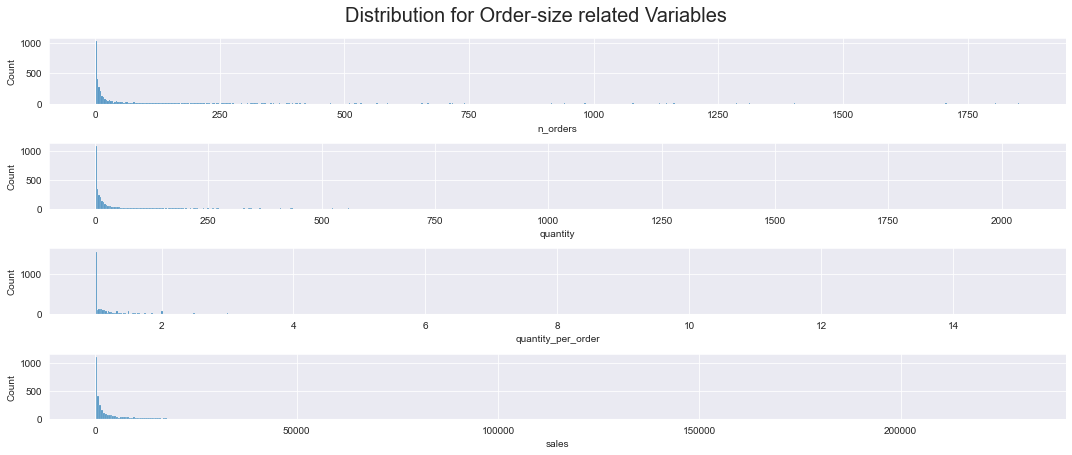

In [205]:
fig, (ax1, ax2, ax3, ax2) = plt.subplots(4,1)
plt.figure(figsize=(15,6)).suptitle('Distribution for Order-size related Variables', fontsize=20)
plt.close(1)

#'n_orders'
ax1 = plt.subplot(411)
ax1 = sns.histplot(sellers.n_orders)
plt.tight_layout()

#'quantity'
ax2 = plt.subplot(412)
ax2 = sns.histplot(sellers.quantity)

#'quantity_per_order'
ax3 = plt.subplot(413)
ax3 = sns.histplot(sellers.quantity_per_order)

#'sales'
ax3 = plt.subplot(414)
ax3 = sns.histplot(sellers.sales)

plt.show();

In [206]:
sellers[['n_orders', 'quantity', 'quantity_per_order', 'sales']].describe()

,n_orders,quantity,quantity_per_order,sales
count,2970.000000,2970.000000,2970.000000,2970.000000
mean,33.617508,38.085185,1.162150,4566.515906
std,107.133714,122.417269,0.443348,14185.211617
min,1.000000,1.000000,1.000000,6.500000
25%,2.000000,3.000000,1.000000,239.800000
50%,7.000000,8.000000,1.000000,893.500000
75%,23.000000,26.000000,1.152009,3586.022500
max,1854.000000,2039.000000,15.000000,229472.630000


The outliers are quite extreme with these variables making the plots difficult to read. We'll re-plot them with an adjusted view that excludes outliers.


In [207]:
# Outlier calculations (based on 1.5*IQR)

features = ['n_orders', 'quantity', 'quantity_per_order', 'sales']

max_xlim = []
q3_xlim = []

for f in features:
    q3 = np.quantile(sellers[f], .75, axis=0) 
    q1 = np.quantile(sellers[f], .25, axis=0) 
    iqr = q3-q1 
    outlier_x = 1.5*iqr
    max_xlim.append(outlier_x)
    q3_xlim.append(q3)

max_xlim

[31.5, 34.5, 0.22801383399209474, 5019.33375]

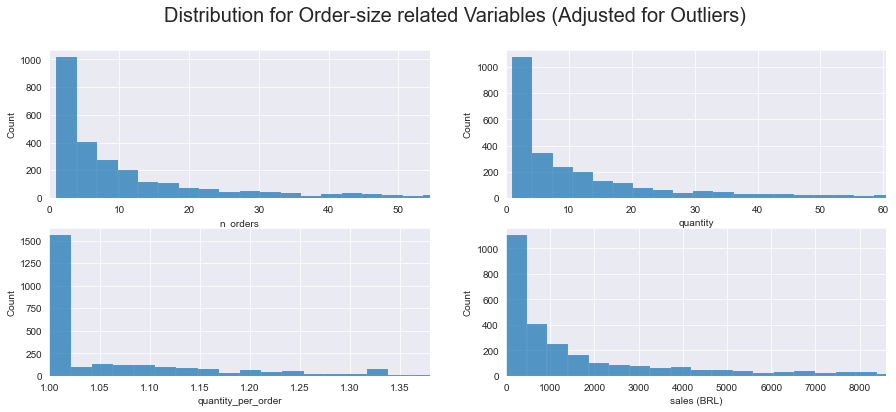

In [216]:
# Re-plotting features with an adjusted view to exclude outliers
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
plt.figure(figsize=(15,6)).suptitle('Distribution for Order-size related Variables (Adjusted for Outliers)', fontsize=20)
plt.close(1)

#'n_orders'
ax1 = plt.subplot(221)
ax1 = sns.histplot(sellers.n_orders)
ax1.set_xlim(0, q3_xlim[0] + max_xlim[0])

#'quantity'
ax2 = plt.subplot(222)
ax2 = sns.histplot(sellers.quantity)
ax2.set_xlim(0, q3_xlim[1] + max_xlim[1])

#'quantity_per_order'
ax3 = plt.subplot(223)
ax3 = sns.histplot(sellers.quantity_per_order)
ax3.set_xlim(1, q3_xlim[2] + max_xlim[2])

#'sales'
ax4 = plt.subplot(224)
ax4 = sns.histplot(sellers.sales)
ax4.set_xlabel('sales (BRL)')
ax4.set_xlim(0, q3_xlim[3] + max_xlim[3])


plt.show();

**Interpretation of Results**

- Since both `n_orders` and `quantity` speak to the volume of product that sellers have sold, it's not surprising that their distribution is similar. However, `n_orders` can be more helpful as a gauge for experience that a seller has in processing orders. 

- With median `n_orders` of only **7**, the platform appears to have many sellers with a low number of transactions which could be a helpful feature in explaining low review scores
 
- The distribution of `quantity_per_order` indicates that most orders deal with a single item. If each order had multiple items, then we might consider that mix-ups in orders could be a factor contributing to low review scores, but here we see a low occurrence of multiple-item orders.  

- `sales` seem to follow a similar distribution with these other variables—a strong right skew, but with the bulk on the low end. Half of all sellers have generated less than **893.50 BRL** (~170 USD).

Another feature that might speak more directly to the experience of the seller is `months_on_olist`, which tells how long a seller has been on the platform.

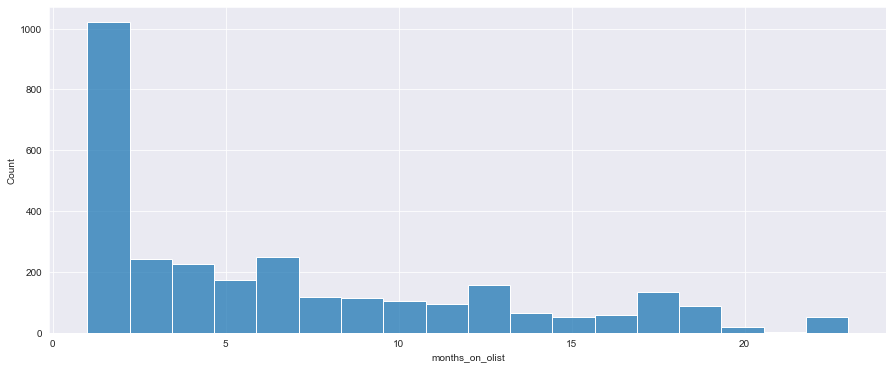

In [196]:
# 'months_on_olist' histogram
plt.figure(figsize=(15,6))
sns.histplot(sellers.months_on_olist)
plt.show()           

In [217]:
# Summary stats 
sellers[['months_on_olist']].describe()

,months_on_olist
count,2970.000000
mean,6.619192
std,5.914010
min,1.000000
25%,1.000000
50%,4.000000
75%,10.000000
max,23.000000


- As a fairly new platform, we can see that the oldest sellers have been using Olist for only **23 months**. And, half of all sellers have only been using the platform for **4 months or less**. 






### Distribution of `seller_review_score`, `share_of_one_stars`, `share_of_five_stars`

These variables indicate how sellers have been performing based on customer feedback.   

- `seller_review_score`: the average score of a seller's reviews 
- `share_of_one_stars`: the proportion of a seller's reviews with only one star 
- `share_of_five_stars`: the proportion of a seller's reviews with fives stars


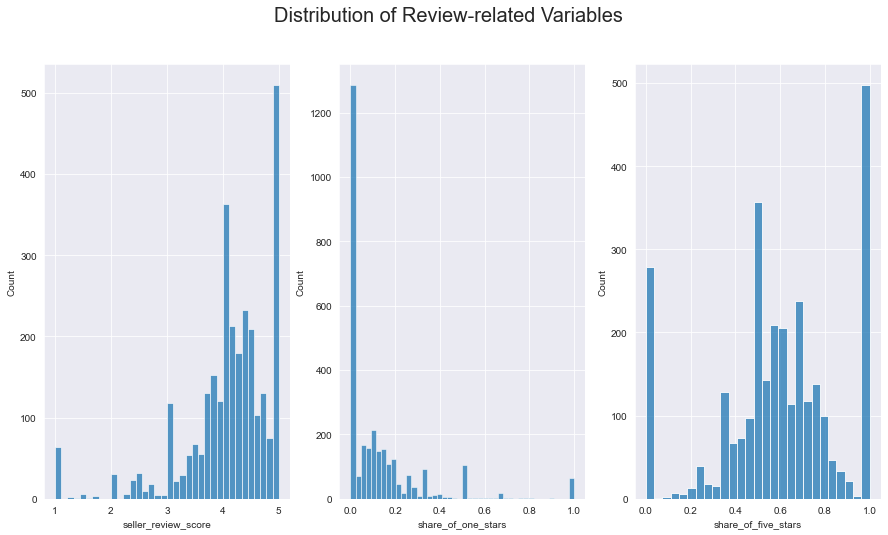

In [137]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
plt.close(1)
plt.figure(figsize=(15,8)).suptitle('Distribution of Review-related Variables', fontsize=20)

#'seller_review_score'
ax1 = plt.subplot(131)
ax1 = sns.histplot(sellers.seller_review_score)

#'share_of_one_stars'
ax2 = plt.subplot(132)
ax2 = sns.histplot(sellers.share_of_one_stars)

#'share_of_five_stars'
ax3 = plt.subplot(133)
ax3 = sns.histplot(sellers.share_of_five_stars)
plt.show();

In [139]:
sellers[['seller_review_score', 'share_of_one_stars', 'share_of_five_stars']].describe()

,seller_review_score,share_of_one_stars,share_of_five_stars
count,2970.000000,2970.000000,2970.000000
mean,4.086880,0.124570,0.592130
std,0.810166,0.191870,0.279057
min,1.000000,0.000000,0.000000
25%,3.818424,0.000000,0.478261
50%,4.200000,0.063856,0.600000
75%,4.625000,0.166667,0.750000
max,5.000000,1.000000,1.000000


**Interpretation of plots**

With these distribution plots, we can see what proportion of sellers have been performing badly with low review scores. This will help us identify and set thresholds for sellers who might be candidates for removal from the platform, or who may be in need of more assistance in improving quality.    

- From our histogram and statistical summary, we can see that the average `seller_review_score` is **close to 4** (mean=4.087), while those receiving an average score of **3 or less** already fall into the bottom 25% of seller performance (Q1=3.82). 

- Examining `share_of_one_stars`, we see that **75% of all sellers** only see a small portion (less than a sixth of reviews, Q3=0.167) of their sales receiving a one-star rating. For the remaining 25% of sellers who are getting a higher proportion of one-star reviews, we can scrutinize their performance further.

- With `share_of_five_stars` we see a W-shaped distribution with three peaks. On the far right, we have a large number of 'super-performers' who have only ever gotten a five-star review. Then we have two smaller peaks occurring a) the center, where only half of their reviews received a 'superb' five-star review, and b) the far left, where a substantial number have never gotten the highest review score. 

For a fairer assessment that takes into consideration the total number of reviews each seller has received, we could explore assigning weights to each 1-star (or 5-star review) that are proportional to the total number of reviews received (i.e. we could control that a seller with a hundred 5-star reviews but a single 1-star review, would still rank higher than a seller with only ten reviews but which are all 5-stars).        

### Correlations

Let's check out the correlations between different features in the Sellers dataset

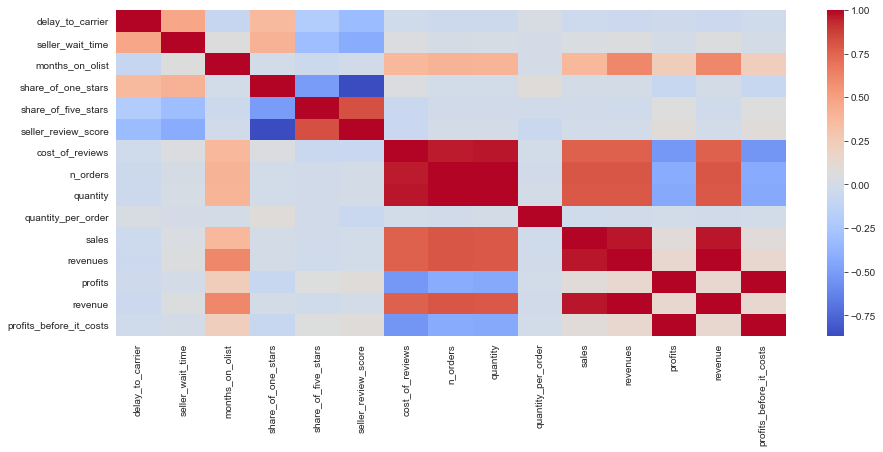

In [94]:
plt.figure(figsize=(15,6))
sns.heatmap(sellers.corr(), cmap='coolwarm');

In [96]:
sellers.corr()['seller_review_score']

delay_to_carrier          -0.325642
seller_wait_time          -0.419605
months_on_olist           -0.019901
share_of_one_stars        -0.869186
share_of_five_stars        0.818685
seller_review_score        1.000000
cost_of_reviews           -0.067521
n_orders                  -0.003983
quantity                  -0.007311
quantity_per_order        -0.064025
sales                     -0.008910
revenues                  -0.013076
profits                    0.085686
revenue                   -0.013321
profits_before_it_costs    0.085541
Name: seller_review_score, dtype: float64

Among features that aren't derived from the `seller_review_score`, similar to the Orders dataset, we have features that capture delivery time such as `delay_to_carrier` (r=-0.33) and `seller_wait_time` (r=-0.42) having the largest correlation with `seller_review_score`. 

Since `seller_wait_time` includes the time a seller ships to the carrier, it makes sense that it is correlated with `delay_to_carrier`.

In [98]:
# correlation between 'seller_wait_time' and 'delay_to_carrier'
sellers.corr()['seller_wait_time']['delay_to_carrier']

0.4723143026385158

# Multivariate Regression  

We'll now run a multivariate regression model with select features from the Sellers dataset to better understand their impact on `seller_review_score`. 

In [99]:
#Applying some feature scaling. Due to large number of outliers among the features, will use standardization over normalization 
#since it does not require scaling based on the range of values. 

def standardize(df, features): 
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized


In [101]:
# Select features and run a multi-variate linear regression model to determine how much each feature impacts review score
features = ['delay_to_carrier', 'seller_wait_time', 'months_on_olist', 'n_orders', 'quantity', 'quantity_per_order', 'sales']
sellers_standardized = standardize(sellers, features)
model = smf.ols(formula=f"seller_review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

In [102]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     seller_review_score   R-squared:                       0.201
Model:                             OLS   Adj. R-squared:                  0.199
Method:                  Least Squares   F-statistic:                     106.3
Date:                 Wed, 11 Aug 2021   Prob (F-statistic):          3.46e-139
Time:                         22:27:12   Log-Likelihood:                -3255.8
No. Observations:                 2970   AIC:                             6528.
Df Residuals:                     2962   BIC:                             6575.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0869      0.013    307.144      0.000       4.061       4.113
delay_to_carrier      -0.1329      0.015     -8.716      0.000      -0.163      -0.103
seller_wait_time      -0.2765      0.015    -18.150      0.000      -0.306      -0.247
months_on_olist       -0.0082      0.015     -0.553      0.580      -0.037       0.021
n_orders               0.1052      0.118      0.888      0.374      -0.127       0.337
quantity              -0.1161      0.117     -0.991      0.322      -0.346       0.114
quantity_per_order    -0.0447      0.014     -3.308      0.001      -0.071      -0.018
sales                  0.0088      0.022      0.396      0.692      -0.035       0.052
==============================================================================
Omnibus:                      813.774   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2772.176
Skew:                          -1.351   Prob(JB):                         0.00
Kurtosis:                       6.886   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation of Results:

- This model has a low R2 (~0.20) suggesting that the currently selected features only explain 20% of the variance
found in the review scores. The f-proba shows that our R2 is statistically significant and that
it performs better than a model without any features.
- The coefficients for the features 'months_on_olist', 'n_orders', 'quantity', and 'sales' are not statistically significant as their p-values are not less than 0.05. Additionally, we see that a value of 0 falls within the 95% confidence interval. Since a zero coefficient would indicate that the feature has no impact on the target variable (i.e. what we state with the null hypothesis), we can't reject the null hypothesis and the coefficients are not reliable (statistically significant). Consider removing[??].


In [104]:
# REVISED FEATURE SELECTION
features = ['delay_to_carrier', 'seller_wait_time', 'quantity_per_order']
sellers_standardized = standardize(sellers, features)
revised_model = smf.ols(formula=f"seller_review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

In [105]:
revised_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     seller_review_score   R-squared:                       0.200
Model:                             OLS   Adj. R-squared:                  0.200
Method:                  Least Squares   F-statistic:                     247.7
Date:                 Wed, 11 Aug 2021   Prob (F-statistic):          2.08e-143
Time:                         22:29:15   Log-Likelihood:                -3256.6
No. Observations:                 2970   AIC:                             6521.
Df Residuals:                     2966   BIC:                             6545.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0869      0.013    307.268      0.000       4.061       4.113
delay_to_carrier      -0.1315      0.015     -8.710      0.000      -0.161      -0.102
seller_wait_time      -0.2776      0.015    -18.391      0.000      -0.307      -0.248
quantity_per_order    -0.0468      0.013     -3.519      0.000      -0.073      -0.021
==============================================================================
Omnibus:                      797.448   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2693.675
Skew:                          -1.326   Prob(JB):                         0.00
Kurtosis:                       6.838   Cond. No.                         1.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
model.params

Intercept             4.086880
delay_to_carrier     -0.132853
seller_wait_time     -0.276461
months_on_olist      -0.008158
n_orders              0.105213
quantity             -0.116118
quantity_per_order   -0.044664
sales                 0.008822
dtype: float64

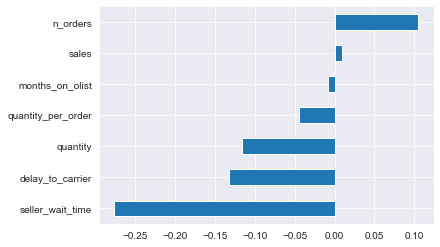

In [107]:
model.params[1:].sort_values().plot(kind='barh');

In [108]:
model.rsquared

0.20074928674431547

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'months_on_olist' is not defined
    seller_review_score ~ delay_to_carrier+ seller_wait_time+ months_on_olist+ n_orders+ quantity+ quantity_per_order+ sales
                                                              ^^^^^^^^^^^^^^^

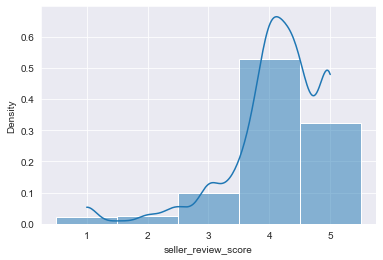

In [110]:
sns.histplot(sellers['seller_review_score'], kde=True, stat='density', discrete=True)
sns.histplot(model.predict(sellers_standardized[features]), kde=True, stat='density', discrete=True);


In [ ]:
sns.histplot(model.resid, kde=True, stat='density', discrete=True);

In [ ]:
plt.figure(figsize=(15,6))
sns.heatmap(sellers.corr(), cmap='coolwarm');

In [ ]:
plt.figure(figsize=(15,6))
sns.heatmap(sellers.corr(method='spearman'), cmap='coolwarm');

# for SPearman = One of the variable is categorical and ordered (ordinal).